# T<sub>2</sub> Hahn Characterization

The purpose of the $T_2$ Hahn Echo experiment is to determine $T_2$ qubit property. 

In this experiment, we would like to get a more precise estimate of the qubit's decay time. $T_2$ represents the amount of time required for the transverse magnetization to fall to approximately 37% ($\frac{1}{e}$) of its initial value.

Since the qubit is exposed to other types of noise (like $T_1$), we are using a $Rx(\pi)$ pulse for decoupling and to solve our inaccuracy for the qubit frequency estimation.

In [27]:
import qiskit
from qiskit_experiments.library.characterization.t2hahn import T2Hahn

The circuit used for the experiment comprises the following:

    1. Rx gate
    2. delay
    3. measurement

The user provides as input a series of delays in seconds. During the delay, we expect the qubit to precess about the z-axis. Because of the echo gate ($Rx(\pi)$) for each echo, the angle after the delay gates will be $\theta_{new} = \theta_{old} + \pi$. after wating the same delay time, the angle will be approximly $0$ or $\pi$. By varying the extension of the delays, we get a series of decaying measurements. We can draw the graph of the resulting function and can analytically extract the desired values.

In [28]:
qubit = 0
# set the desired delays
conversion_factor = 1e-6 # our delay will be in micro-sec
delays = list(range(1, 50, 1) )
delays = [float(_) * conversion_factor for _ in delays]
number_of_echoes = 1

# Create a T2Hahn experiment. Print the first circuit as an example
exp1 = T2Hahn(qubit=qubit, delays=delays, num_echoes=number_of_echoes)
print(exp1.circuits()[0])

     ┌─────────┐┌─────────────────┐┌───────┐┌─────────────────┐┌─────────┐┌─┐
  q: ┤ Rx(π/2) ├┤ Delay(1e-06[s]) ├┤ Rx(π) ├┤ Delay(1e-06[s]) ├┤ Rx(π/2) ├┤M├
     └─────────┘└─────────────────┘└───────┘└─────────────────┘└─────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════════════╩═
                                                                           0 


We run the experiment on a simple, simulated backend, created specifically for this experiment's tutorial.

In [29]:
from qiskit_experiments.test.t2hahn_backend import T2HahnBackend

estimated_t2hahn = 20 * conversion_factor
# The behavior of the backend is determined by the following parameters
backend = T2HahnBackend(
    t2hahn=[estimated_t2hahn],
    frequency=[100100],
    initialization_error=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],
)

The resulting graph will have the form:
$f(t) = a \cdot e^{-\frac{t}{T_2}}+ b$
where *t* is the delay and $T_2$ is the decay factor.

c:\users\014780756\documents\github_2\qiskit_experiments\curve_analysis\curve_fit.py:137: RuntimeWarning: invalid value encountered in sqrt
  popt_err = np.sqrt(np.diag(pcov))


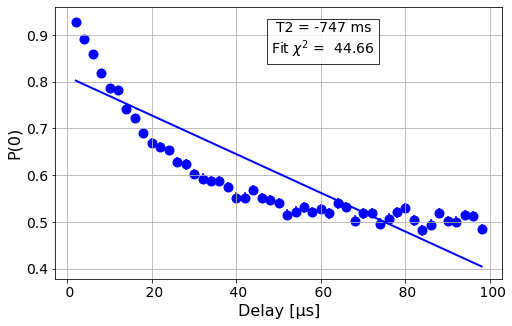

In [22]:
exp1.analysis.set_options(p0=None, plot=True)
expdata1 = exp1.run(backend=backend, shots=2000)
expdata1.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
display(expdata1.figure(0))

In [6]:
# Print results
for result in expdata1.analysis_results():
    print(result)

DbAnalysisResultV1
- name: @Parameters_T2HahnAnalysis
- value: [4.73150237e-01 5.03648507e-01 1.98283007e-05] ± [5.15527149e-03 3.03978247e-03 5.77292515e-07]
- χ²: 0.7488240853426195
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T2
- value: 1.9828300732126065e-05 ± 5.772925151075391e-07 s
- χ²: 0.7488240853426195
- quality: good
- device_components: ['Q0']
- verified: False


### Providing initial user estimates
The user can provide initial estimates for the parameters to help the analysis process. Because the curve is expected to decay toward $0.5$, the natural choice for parameter $B$ is $0.5$. Since if there was no delay we would expect that the probability to measure `1` is $100\%$, so we will guess that A is $0.5$. In this experiment, `t2hahn` is the parameter of interest. Good estimate for it is the value computed in previous experiments on this qubit or a similar value computed for other qubits.

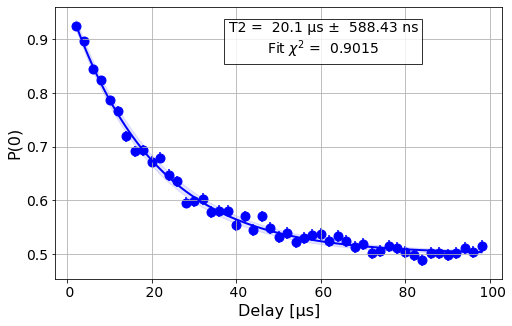

In [23]:
exp_with_p0 = T2Hahn(qubit=qubit, delays=delays, num_echoes=number_of_echoes)
exp_with_p0.analysis.set_options(p0={"amp": 0.5, "tau": estimated_t2hahn, "base": 0.5})
expdata_with_p0 = exp_with_p0.run(backend=backend, shots=2000)
expdata_with_p0.block_for_results()

# Display fit figure
display(expdata_with_p0.figure(0))

In [8]:
# Print results
for result in expdata_with_p0.analysis_results():
    print(result)

DbAnalysisResultV1
- name: @Parameters_T2HahnAnalysis
- value: [4.78978431e-01 5.02409209e-01 2.01192655e-05] ± [5.09032092e-03 3.07792331e-03 5.78387141e-07]
- χ²: 0.5509343846546172
- quality: good
- extra: <4 items>
- device_components: ['Q0']
- verified: False
DbAnalysisResultV1
- name: T2
- value: 2.011926549231594e-05 ± 5.783871411742618e-07 s
- χ²: 0.5509343846546172
- quality: good
- device_components: ['Q0']
- verified: False


### Number of echoes
The user can provide the number of echoes that the circuit will perform. This will determine the amount of delay and echo gates. As the number of echoes increases, the total time of the circuit will grow. The echoes decrease the effects of $T_{1}$ noise and frequency inaccuracy estimation. Due to that, the Hahn Echo experiment improve our estimate for $T_{2}$ better. In the following code, we will compare results of the Hahn experiment with `0` echoes and `4` echoes.
Note, that the provided delay time is the for each delay in the circuit and not the total time.

In [ ]:
import numpy as np

qubit2 = 0
# set the desired delays
conversion_factor = 1e-6

delays2 = np.append(
                    (np.linspace(1.0, 10.0, num=37)).astype(float),
                    (np.linspace(10.5, 45.0, num=70)).astype(float),
                )
delays2 = [float(_) * conversion_factor for _ in delays2]
num_echoes = 4
estimated_t2hahn2 = 20 * conversion_factor


# Create a T2Hahn experiment with 0 echoes
exp2_0echoes = T2Hahn(qubit2, delays2, num_echoes=0)
exp2_0echoes.analysis.set_options(p0={"amp": 0.5, "tau": estimated_t2hahn2, "base": 0.5})
print("The first circuirs of hahn echo experiment with 0 echoes:")
print(exp2_0echoes.circuits()[0])



# Create a T2Hahn experiment with 4 echoes. Print the first circuit as an example
exp2_4echoes = T2Hahn(qubit2, delays2, num_echoes=4)
exp2_4echoes.analysis.set_options(p0={"amp": 0.5, "tau": estimated_t2hahn2, "base": 0.5})
print("The first circuirs of hahn echo experiment with 4 echoes:")
print(exp2_4echoes.circuits()[0])


C:\Users\014780756\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:659: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
Analysis callback <function BaseAnalysis.run.<locals>.run_analysis at 0x0000024CCD9BFEE0> failed:
Traceback (most recent call last):
  File "c:\users\014780756\documents\github_2\qiskit_experiments\database_service\db_experiment_data.py", line 299, in _wrapped_callback
    callback(self, **kwargs)
  File "c:\users\014780756\documents\github_2\qiskit_experiments\framework\base_analysis.py", line 168, in run_analysis
    results, figures = analysis._run_analysis(expdata)
  File "c:\users\014780756\documents\github_2\qiskit_experiments\curve_analysis\curve_analysis.py", line 841, in _run_analysis
    fit_options = self._generate_fit_guesses(default_fit_opt)
  File "c:\users\014780756\documents\github_2\qiskit_experiments\curve_analysis\standard_analysis\decay.py", line 82, in _generate_fit_guesses
    alpha = curve.guess.exp_decay(curve_data.x

Hahn Echoe with 0 echoes:
Hahn Echoe with 4 echoes:


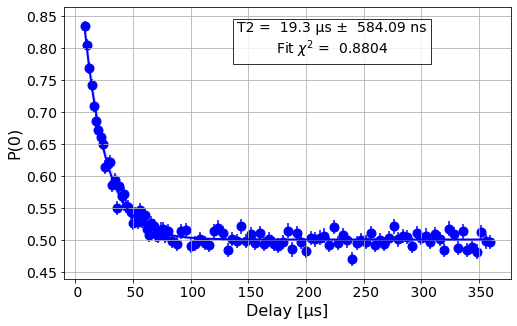

In [35]:
from qiskit_experiments.test.t2hahn_backend import T2HahnBackend

estimated_t2hahn2 = 20 * conversion_factor
# The behavior of the backend is determined by the following parameters
backend2 = T2HahnBackend(
    t2hahn=[estimated_t2hahn2],
    frequency=[100100],
    initialization_error=[0.0],
    readout0to1=[0.02],
    readout1to0=[0.02],)

# Analysis for Hahn Echoe experiemnt with 0 echoes.
expdata2_0echoes = exp2_0echoes.run(backend=backend2, shots=2000)
expdata2_0echoes.block_for_results()  # Wait for job/analysis to finish.

# Analysis for Hahn Echoe experiemnt with 4 echoes.
expdata2_4echoes = exp2_4echoes.run(backend=backend2, shots=2000)
expdata2_4echoes.block_for_results()  # Wait for job/analysis to finish.

# Display the figure
print("Hahn Echoe with 0 echoes:")
# display(expdata2_0echoes.figure(0))
print("Hahn Echoe with 4 echoes:")
display(expdata2_4echoes.figure(0))

In [37]:
expdata2_0echoes.data()[0]

{'counts': {'0': 1961, '1': 39},
 'job_id': 0,
 'metadata': {'experiment_type': 'T2Hahn',
  'qubit': 0,
  'xval': 0.0,
  'unit': 's'},
 'shots': 2000,
 'meas_level': <MeasLevel.CLASSIFIED: 2>}

###  $T_{2}$ versus  $T_{2}^{\ast}$
This experiment purpose is to give a better estimate for the dephasing noise. In Ramsey experiment, we can estimate $T_{2}^{\ast}$ but this is not truly the dephasing noise as the information is not lost.
The $\ast$ indicates that $T_{2}^{\ast}$ is sensitive to inhomogeneous broadening. This affect the qubit frequncy.
In Ramsey experiment, we estimate the frequency of the qubit while in Hahn Echo experiment there is no need.\
Firslty, let us get backend property from the the quantum computer.

In [15]:
from qiskit import IBMQ
from qiskit_experiments.library.characterization.t2hahn import T2Hahn
import qiskit
from qiskit_experiments.library import T2Ramsey

def backend_fetcher():
    # TOKEN = ""
    # IBMQ.save_account(TOKEN)
    IBMQ.load_account() # Load account from disk
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend('ibmq_manila')
    backend_properties = backend_manila.properties()
    return backend, backend_properties


backend, backend_properties = backend_fetcher()
estimated_t2hahn = backend_properties.t2(0)

# Hahn Echo experiment parameters
qubit_hahn = 0
conversion_factor = 1e-6
delays2 = np.append(
                    (np.linspace(1.0, 10.0, num=37)).astype(float),
                    (np.linspace(10.5, 45.0, num=70)).astype(float),
                )
delays2 = [float(_) * conversion_factor for _ in delays2]
num_echoes = 4

exp3_hahn = T2Hahn(qubit_hahn, delays2, num_echoes=num_echoes, backend=backend)
exp3_hahn.analysis.set_options(p0={"amp": 0.5, "tau": estimated_t2hahn, "base": 0.5}, plot=True)
expdata_hahn = exp3_hahn.run(backend=backend_manila, shots=2000).block_for_results()

# Ramsey experiment parameters
qubit_ramsey = 0
delays_ramsey = list(range(1, 350, 2))
delays_ramsey = [float(_) * conversion_factor for _ in delays_ramsey]

# Create a T2Ramsey experiment. Print the first circuit as an example
exp_ramsey = T2Ramsey(qubit_ramsey, delays_ramsey, osc_freq=freq_manila, backend=backend_manila)

backend, backend_properties = backend_fetcher()
# Analysis
default_p0 = {
            "A": 0.5,
            "T2star": estimated_t2hahn,
            "f": backend_properties.frequency(0),
            "phi": 0,
            "B": 0.5,
        }
exp_ramsey.analysis.set_options(p0=default_p0, plot=True)

# Run the Ramsey experiment
expdata_ramsey = exp_ramsey.run(backend=backend, shots=2000).block_for_results()


ibmqfactory.load_account:WARNING:2021-12-27 17:11:38,733: Credentials are already in use. The existing account in the session will be replaced.


We can see that the backend has $T_2 = 20 [\mu s]$. We can see the estimate $T_2$ from both experiments:

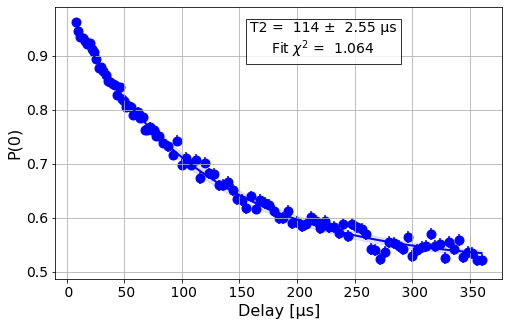

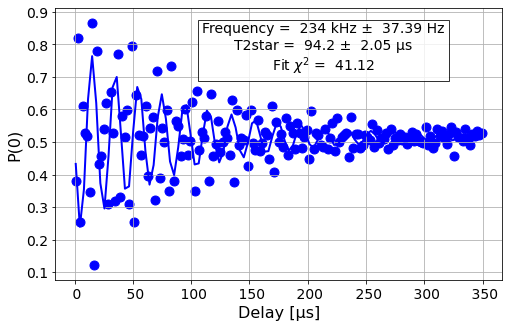

In [26]:
import matplotlib.pyplot as plt

display(expdata_hahn.figure(0), expdata_ramsey.figure(0))

In [17]:
import qiskit.tools.jupyter
%qiskit_copyright